# Семинар 5. Кластеризация


In [2]:
import torch

In [1]:
torch.cuda.is_available()

NameError: name 'torch' is not defined

## Протеом человека и кластеризация

Посмотрим на протеом человека -- набор из 20,607 белков (для простоты по одному белку от гена).

Начнем не с готового датасета, а с fasta файла, взятого из [UniProt Proteomes](https://www.uniprot.org/proteomes/UP000005640).

Воспользуемся последними наработками для получения векторных репрезентаций этих белков, а в конце посмотрим, насколько кластеры белков соотносятся с их функциями.

### Установка ряда полезных пакетов и полезные функции

In [ ]:
!pip install umap-learn biopython transformers mygene sentencepiece sentence-transformers

In [4]:
import torch

In [5]:
# Параметры
MAX_LEN = 512  # to avoid CUDA OOM error
BATCH_SIZE = 4
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [1]:
import re

from Bio import SeqIO
from mygene import MyGeneInfo

import pandas as pd
import numpy as np
import seaborn as sns
import pylab as plt
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation
from sklearn.decomposition import PCA
from umap import UMAP

mygene_client = MyGeneInfo()

Для получения эмбеддингов белков будем использовать [ProtBERT](https://arxiv.org/pdf/2007.06225.pdf).

In [3]:
from sentence_transformers.models import Pooling, Transformer
from sentence_transformers import SentenceTransformer

model_trf = Transformer("Rostlab/prot_bert", max_seq_length=MAX_LEN)
pooling = Pooling(model_trf.get_word_embedding_dimension())
model = SentenceTransformer(modules=[model_trf, pooling])

NameError: name 'MAX_LEN' is not defined

Для удобства раскрашивания белков по молекулярным функциям стоит воспользоваться `MultiLabelBinarizer`

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer


def get_labels(list_of_mf_terms):
  """Return a DataFrame with binary labels for each term"""
  binarizer = MultiLabelBinarizer()
  labels = binarizer.fit_transform(list_of_mf_terms)
  return pd.DataFrame(labels, columns=binarizer.classes_)

In [4]:
# some helper functions
def get_seq_ac(seq):
  """Return UniProt Ac of the Seq"""
  return seq.name.split("|")[1]


def normalize_seq(seq):
  """Return tokenizer-ready protein sequence"""
  seq = re.sub(r"[UZOB]", "X", str(seq.seq))
  return " ".join(seq)

### Загружаем протеомы

In [ ]:
!wget https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Eukaryota/UP000005640/UP000005640_9606.fasta.gz
!gunzip *.gz

In [ ]:
# загружаем протеом в память (не делайте так, если у вас ну очень много белков)
sequences = list(SeqIO.parse("UP000005640_9606.fasta", format="fasta"))
# достаем UniProt AC, чтобы достать molecular functions из аннотаций Gene Ontology 
uniprot_acs = [get_seq_ac(seq) for seq in sequences]  

Посмотрим, что лежит в отдельных последовательностях.

In [ ]:
sequences[0]

SeqRecord(seq=Seq('MRLPAQLLGLLMLWVPGSSGDVVMTQSPLSLPVTLGQPASISCRSSQSLVYSDG...HWP'), id='sp|A0A075B6S6|KVD30_HUMAN', name='sp|A0A075B6S6|KVD30_HUMAN', description='sp|A0A075B6S6|KVD30_HUMAN Immunoglobulin kappa variable 2D-30 OS=Homo sapiens OX=9606 GN=IGKV2D-30 PE=3 SV=1', dbxrefs=[])

Ну и достанем GO аннотации из сервиса [MyGene](https://mygene.info/). 

In [ ]:
gomf_annotations = mygene_client.querymany(
    uniprot_acs, 
    scopes="uniprot",
    fields="go.MF",
    species="human",
    as_dataframe=True
)
gomf_annotations

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-20607...done.
Finished.
219 input query terms found dup hits:
	[('P0C0S8', 5), ('P0DPH9', 2), ('Q96QH8', 2), ('B3EWG5', 3), ('P86481', 5), ('Q08648', 2), ('Q0WX57'
1736 input query terms found no hit:
	['A0A075B6S6', 'A0A1W2PPE2', 'A0A5A2', 'P0DP07', 'Q6NSW7', 'Q6ZRV3', 'A0A0A0MTA2', 'A0A0A0MTA3', 'A0
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


,notfound,_id,_score,go.MF.category,go.MF.evidence,go.MF.id,go.MF.qualifier,go.MF.term,go.MF.pubmed,go.MF
query,,,,,,,,,,
A0A075B6S6,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0A1W2PPE2,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0A5A2,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0PJE2,NaN,79758,20.045069,MF,IEA,GO:0016491,enables,oxidoreductase activity,NaN,NaN
A1A580,NaN,337963,19.201490,MF,IPI,GO:0005515,enables,protein binding,"[25416956, 32296183]",NaN
...,...,...,...,...,...,...,...,...,...,...
P0DMU3,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q6ZSN1,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q96M85,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Мда, ну очень некрасивый DataFrame. Оставим только go.MF.term и причешем датасет немного, удалив белки без аннотаций.

In [ ]:
gomf_annotations = gomf_annotations.groupby("query")["go.MF.term"].agg(lambda x: x.dropna().tolist())
# напоминаю, что поле pd.DataFrame.str работает и с питоновскими листами внутри датафрейма 
gomf_annotations = gomf_annotations.loc[gomf_annotations.str.len() > 0]  # drop empty lists
gomf_annotations

query
A0A087WVF3                          [GTPase activator activity]
A0A087WWA1    [1-phosphatidylinositol-3-kinase regulator act...
A0A087WXS9                          [GTPase activator activity]
A0A087X179                          [GTPase activator activity]
A0A087X1G2                          [GTPase activator activity]
                                    ...                        
Q9Y6W8                                        [protein binding]
Q9Y6X1                                        [protein binding]
Q9Y6X4                                        [protein binding]
Q9Y6Y0                                        [protein binding]
W5XKT8                                        [protein binding]
Name: go.MF.term, Length: 2810, dtype: object

Гораздо лучше. Возможно, лучше использовать все белки, не удаляя те, что без аннотированной функции. Напишите соображения по этому поводу, перечислив все "за" и "против". Лучше предварительно ознакомиться с тем, что необходимо сделать в задании.


***Ваш ответ***

### Получаем эмбеддинги

In [ ]:
valid_acs = set(gomf_annotations.index)

prepared_sequences = pd.DataFrame(
    [(get_seq_ac(seq), normalize_seq(seq)) for seq in sequences], 
    columns=["ac", "sequence"]
)
prepared_sequences = prepared_sequences.loc[prepared_sequences.ac.isin(valid_acs)]
prepared_sequences["molecular_function"] = prepared_sequences.ac.map(gomf_annotations)
prepared_sequences

,ac,sequence,molecular_function
3,A0PJE2,M S L Y R S V V W F A K G L R E Y T K S G Y E ...,[oxidoreductase activity]
4,A1A580,M S Y N C C C G N F S S H S C E G Y L C Y S G ...,[protein binding]
33,Q09019,M A A G G A E G G S G P G A A M G D C A E I K ...,[molecular_function]
46,Q6NV75,M S D E R R L P G S A V G W L V C G G L S L L ...,[G protein-coupled receptor activity]
47,Q6NZY7,M P V L K Q L G P A Q P K K R P D R G A L S I ...,[small GTPase binding]
...,...,...,...
20565,Q96D03,M V A T G S L S S K N P A S I S E L L D C G Y ...,[protein binding]
20570,Q96S15,M E K M S R V T T A L G G S V L T G R T M H C ...,[protein binding]
20579,Q9H6E4,M D L L Q F L A F L F V L L L S G M G A T G T ...,[protein binding]
20584,Q9NVR5,M A K A A A S S S L E D L D L S G E E V Q R L ...,[protein binding]


In [ ]:
labels = get_labels(prepared_sequences.molecular_function)  # используйте это для покраски и других заданий

In [ ]:
import gc
del sequences # free some memory
gc.collect()

48

In [ ]:
embeddings = model.encode(
    prepared_sequences.sequence.tolist(), 
    show_progress_bar=True,
    batch_size=BATCH_SIZE,
    device=DEVICE,
    convert_to_numpy=True
)

Batches:   0%|          | 0/703 [00:00<?, ?it/s]

In [ ]:
np.save("embeddings.npy", embeddings)

### Пример работы с кластеризацией

Обратите внимание, что здесь приведен только небольшой пример, который отличается от задания.

In [ ]:
# if you'd like to skip previous parts
embeddings = np.load("embeddings.npy")

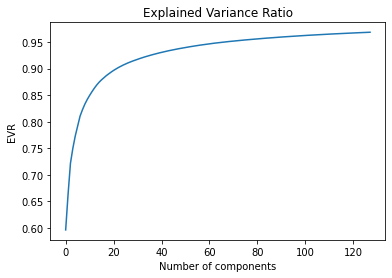

In [ ]:
pca = PCA(n_components=128)
pca_embeddings = pca.fit_transform(embeddings)

plt.title("Explained Variance Ratio")
plt.xlabel("Number of components")
plt.ylabel("EVR")
sns.lineplot(
    x=np.arange(pca.explained_variance_ratio_.shape[0]),
    y=np.cumsum(pca.explained_variance_ratio_)
)
print()

Возьму 20 компонент, они объясняют около 90% всей дисперсии. Это должно помочь справиться с проклятьем размерности при кластеризации.

In [ ]:
cluterer = AffinityPropagation()
clusters = cluterer.fit_predict(pca_embeddings[:, :20])

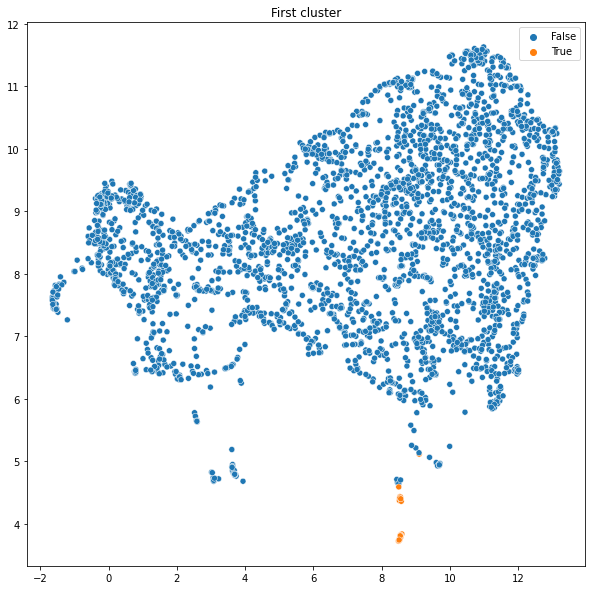

In [ ]:
ump = UMAP(n_components=2)
umap_embeddings = ump.fit_transform(pca_embeddings[:, :20])

plt.figure(figsize=(10, 10))
plt.title("First cluster")
sns.scatterplot(
    x=umap_embeddings[:, 0],
    y=umap_embeddings[:, 1],
    hue=clusters==1
)
print()

In [ ]:
labels[clusters==1].describe().T.sort_values("mean", ascending=False).head(5)

,count,mean,std,min,25%,50%,75%,max
calcium ion binding,28.0,0.964286,0.188982,0.0,1.0,1.0,1.0,1.0
cell-cell adhesion mediator activity,28.0,0.035714,0.188982,0.0,0.0,0.0,0.0,1.0
1-phosphatidylinositol-3-kinase regulator activity,28.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
phospholipase activity,28.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
phosphotyrosine residue binding,28.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


Тут кластер $Ca^{2+}$-связывающих белков.

А дальше -- кластер GPCR.

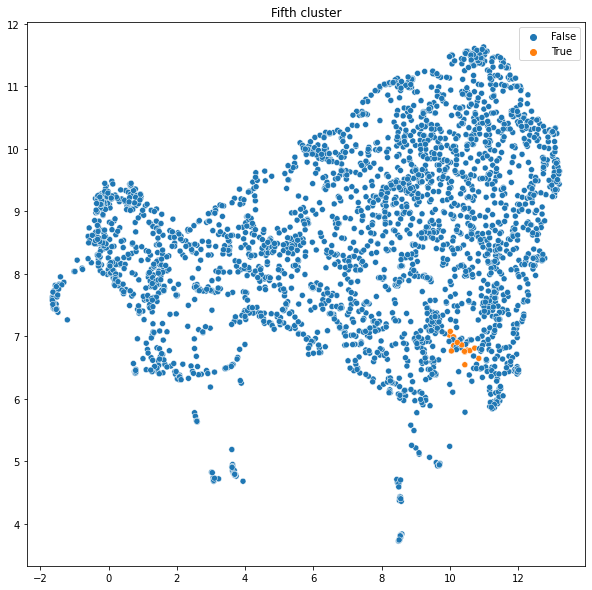

,count,mean,std,min,25%,50%,75%,max
protein binding,15.0,0.600000,0.507093,0.0,0.0,1.0,1.0,1.0
G protein-coupled receptor activity,15.0,0.133333,0.351866,0.0,0.0,0.0,0.0,1.0
signaling receptor activity,15.0,0.066667,0.258199,0.0,0.0,0.0,0.0,1.0
molecular_function,15.0,0.066667,0.258199,0.0,0.0,0.0,0.0,1.0
transmembrane transporter activity,15.0,0.066667,0.258199,0.0,0.0,0.0,0.0,1.0


In [ ]:
plt.figure(figsize=(10, 10))
plt.title("Fifth cluster")
sns.scatterplot(
    x=umap_embeddings[:, 0],
    y=umap_embeddings[:, 1],
    hue=clusters==5
)
plt.show()
labels[clusters==5].describe().T.sort_values("mean", ascending=False).head(5)

### Собственно ваше задание

Что хочется от вас увидеть:
1. Уменьшите размерность данных с помощью PCA до 64.
2. Постройте кластеризацию KMeans, найдите оптимальный K с помощью [Silhoette score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html).
3. С помощью UMAP постройте scatter plot с покраской по терминам GO MF. Можете взять два любых, но советую 
  - `GTPase activator activity`
  - `RNA binding`
  - `serine-type endopeptidase activity`
4. Ответьте на вопрос: есть ли кластеры, явно обогащенные белками с выбранной MF? Если да, посчитайте Matthews correlation для такого кластера и MF.
5. Попробуйте кластеризацию DBSCAN, подобрав правильные параметры. Ответьте на тот же вопрос.
